In [1]:
import sys
import os
import numpy as np
import pandas as pd
import random
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import shape, box, LineString, MultiPolygon, Polygon, MultiPoint, Point, LinearRing
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.__version__}")
print(f"Shapely GEOS version {shapely.geos_version_string}")
print(f"Shapely GEOS C API version {shapely.geos_capi_version_string}")

# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

Py version 3.8.10
Shapely version 2.0.1
Shapely GEOS version 3.11.1
Shapely GEOS C API version 3.11.1-CAPI-1.17.1
RasDaMan is running


In [40]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    ring = LinearRing(zip(long_array, lat_array))
    return ring
  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

        
def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: Polygon Ring Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = processPOLYGON(mainPOLYGON)
#         for i in range(0, len(inputPOLYGON.interiors)):
#             gridRING_yx = processRING(inputPOLYGON.interiors[i])
        
#         gridPOLYGON_yx_assembled = gridPOLYGON_yx.symmetric_difference(Polygon(gridRING_yx))
        
        return gridPOLYGON_yx #return gridPOLYGON_yx_assembled
           

######## Mother Function ##############################################################################################
########################################################################################

def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(unary_union(gridMULTI))
#         return shapely.geometry.MultiPolygon(gridMULTI)

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
######## GIS F(X) ##############################################################################################
################################################################################################################


def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    print(type(result))
    return result

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return True #return numpy_array  


def vizVectorGeom(input_geom):
#     geojson = {'type': 'Polygon', 'coordinates': [[[34, 31], [32, 31], [34, 33]]]}
    gdf = gpd.GeoDataFrame({'geometry':[shape(input_geom)]}, crs='EPSG:4326')
    ax = gdf.plot( facecolor='#80a4ff33', edgecolor='red', linewidth=1)
    cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=10)
    plt.show()
    print(input_geom.geom_type)

In [3]:
gdfBAV = gpd.read_file('/home/arkaghosh/Downloads/Baveria/Vector/Baveria_1.shp')
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm2.shp')
raster01_path = '/home/arkaghosh/Downloads/Baveria/Raster/Baveria_Temp_MOD11A1.061_1km_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'

In [32]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values

In [33]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())

ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [34]:
pixel_size = 0.00833333333258679

### München (I)

München


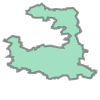

In [287]:
gid = 58 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

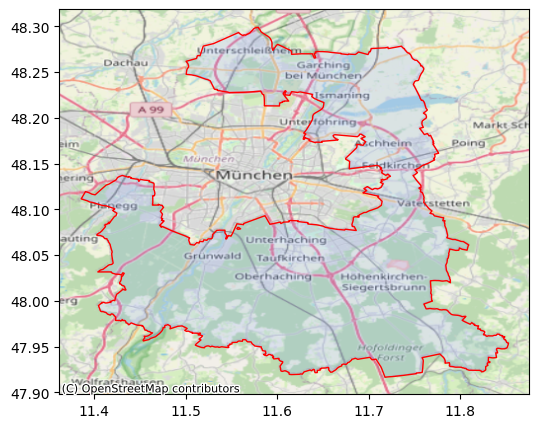

Polygon


In [288]:
vizVectorGeom(INPUT)

In [289]:
qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

58: Polygon is processing
58: Polygon Ring Detected


11.003744360902287

58: Polygon is processing
58: Polygon Ring Detected


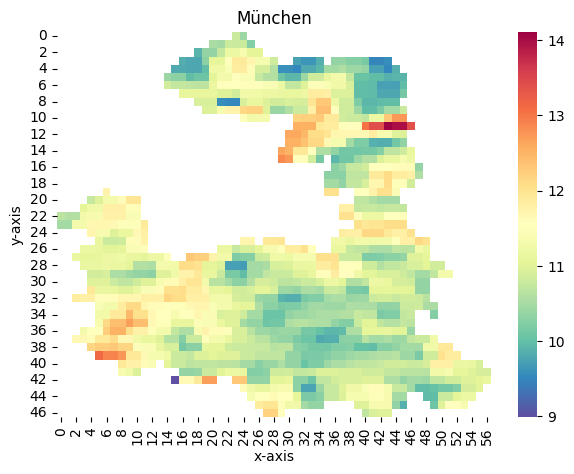

True

In [298]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gdfBAV.NAME_2[gid]), 0)

### Würzburg (II)

Würzburg


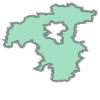

In [300]:
gid = 94 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

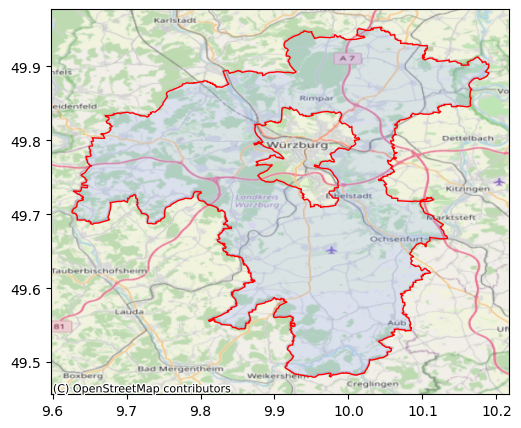

Polygon


In [301]:
vizVectorGeom(INPUT)

In [302]:
qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

94: Polygon is processing
94: Polygon Ring Detected


10.420287664553916

94: Polygon is processing
94: Polygon Ring Detected


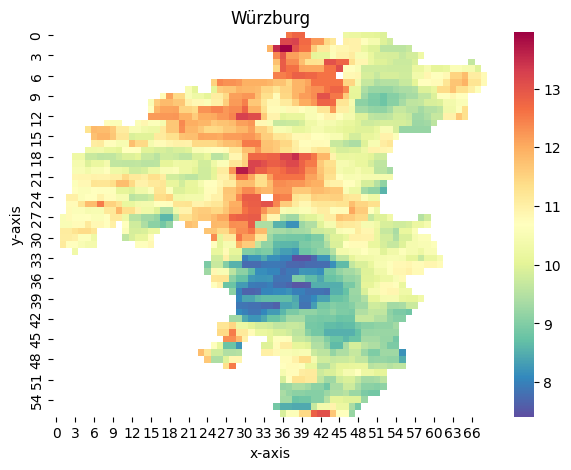

True

In [303]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gdfBAV.NAME_2[gid]), 0)

### Bayreuth (III)

Bayreuth


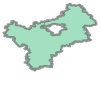

In [274]:
gid = 14 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

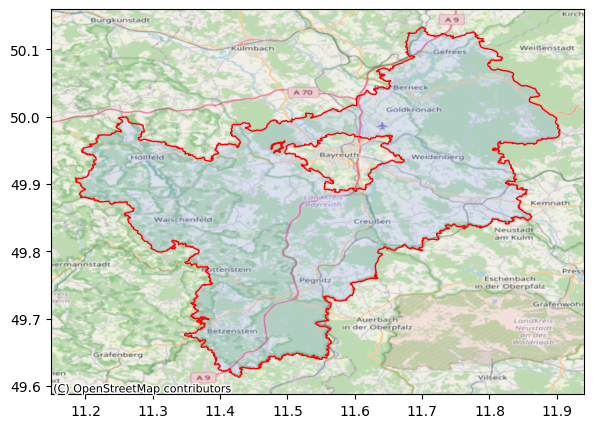

Polygon


In [275]:
vizVectorGeom(INPUT)

In [276]:
qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

14: Polygon is processing
14: Polygon Ring Detected


9.840136778115507

14: Polygon is processing
14: Polygon Ring Detected


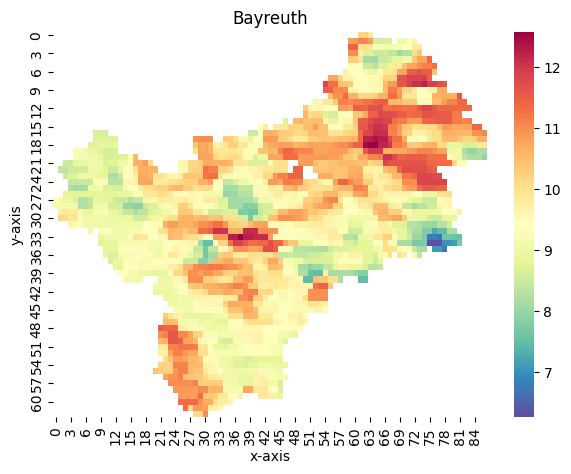

True

In [277]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Bayreuth", 0)

### Cham (IV)

Cham


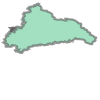

In [43]:
gid = 17 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

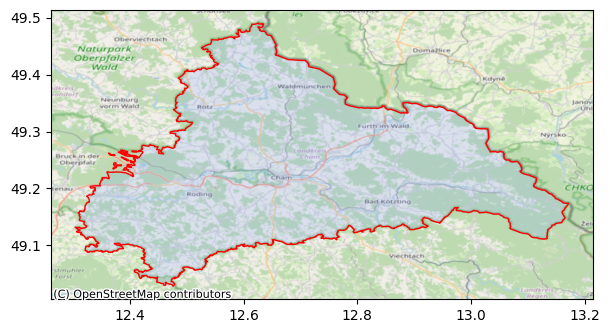

MultiPolygon


In [44]:
vizVectorGeom(INPUT)

In [37]:
list(INPUT.geoms)

[<POLYGON ((12.495 49.061, 12.494 49.061, 12.493 49.06, 12.493 49.06, 12.493 ...>,
 <POLYGON ((12.372 49.237, 12.372 49.237, 12.374 49.238, 12.374 49.238, 12.37...>,
 <POLYGON ((12.379 49.241, 12.381 49.241, 12.385 49.241, 12.385 49.24, 12.381...>,
 <POLYGON ((12.371 49.243, 12.373 49.245, 12.373 49.245, 12.376 49.245, 12.37...>,
 <POLYGON ((12.395 49.25, 12.395 49.25, 12.392 49.251, 12.392 49.251, 12.39 4...>,
 <POLYGON ((12.368 49.26, 12.37 49.259, 12.37 49.259, 12.372 49.26, 12.373 49...>,
 <POLYGON ((12.385 49.267, 12.385 49.267, 12.387 49.267, 12.387 49.267, 12.38...>,
 <POLYGON ((12.408 49.264, 12.408 49.264, 12.407 49.264, 12.405 49.264, 12.40...>]

In [412]:
count = 0
x = 0.0
for polygon in INPUT.geoms:
    qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(polygon)) + ')) from Bavaria_Temperature_MODIS_1km as m'
    x = x + query2numeric(qAGGREGATE)
    count = count+1
    
x_avg = x/count
print(x_avg, count)

None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
10.703588444213464 8


In [417]:
i = 0 
polygons_array2 = []
for polygon in INPUT.geoms:
    gridPOLYGON = processPOLYGON(polygon)
    polygons_array2.append(gridPOLYGON)
    i = i +1
    print(f"flag {i}") # i th inner polygon
            

flag 1
flag 2
flag 3
flag 4
flag 5
flag 6
flag 7
flag 8


In [418]:
polygons_array2

['POLYGON ((180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 422, 180 422, 180 421, 180 421, 181 421, 181 421, 181 421, 181 421, 181 421, 181 420, 181 420, 181 420, 181 421, 181 420, 181 420, 181 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 419, 182 419, 182 420, 182 419, 182 419, 182 419, 182 419, 182 419, 182 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 184 419, 184 419, 184 419, 184 419, 184 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 417, 183 417, 183 417, 183 417, 183 416, 183 416, 183 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 415, 182 415, 182 415, 182 415, 182 414, 182 414, 182 414, 182 414, 182 414, 182 414, 182 414, 182 414, 181 414, 181 414, 181 413, 181 413

In [419]:
gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array2]

In [420]:
gridMULTI

[<POLYGON ((180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 18...>,
 <POLYGON ((159 407, 159 407, 158 407, 158 407, 158 407, 159 407, 159 407, 15...>,
 <POLYGON ((158 408, 158 408, 158 408, 158 408, 158 408, 158 407, 158 407, 15...>,
 <POLYGON ((158 407, 158 407, 158 407, 158 407, 158 407, 158 407, 158 407, 15...>,
 <POLYGON ((157 409, 157 409, 157 409, 157 409, 157 409, 157 409, 157 409, 15...>,
 <POLYGON ((156 406, 156 406, 156 406, 156 407, 156 407, 156 407, 156 407, 15...>,
 <POLYGON ((155 408, 155 408, 155 408, 155 408, 155 408, 155 408, 155 408, 15...>,
 <POLYGON ((155 411, 155 411, 155 411, 155 411, 155 411, 155 410, 155 411, 15...>]

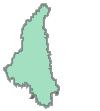

In [421]:
from shapely.ops import unary_union
cu = unary_union(gridMULTI)
cu

In [422]:
print(cu)

MULTIPOLYGON (((157 409, 157 408, 156 408, 157 409)), ((181 420, 182 420, 182 419, 183 419, 183 418, 183 417, 183 416, 182 416, 182 415, 182 414, 181 414, 181 413, 180 413, 180 414, 179 414, 179 413, 178 413, 177 413, 176 413, 176 412, 175 412, 175 411, 175 410, 175 409, 175 408, 176 409, 176 408, 176 407, 176 406, 176 405, 176 404, 176 403, 176 402, 176 401, 175 401, 175 402, 175 403, 174 403, 174 402, 173 402, 173 401, 173 400, 172 400, 172 399, 171 399, 171 400, 170 400, 170 399, 169 400, 169 399, 168 400, 168 401, 167 401, 166 401, 165 401, 164 401, 164 402, 164 403, 163 403, 163 402, 162 402, 162 403, 162 404, 161 404, 161 405, 161 406, 160 405, 160 406, 160 407, 160 408, 160 409, 160 410, 159 410, 159 409, 158 409, 158 410, 157 410, 158 411, 157 411, 157 412, 156 411, 156 412, 156 413, 155 413, 154 413, 154 414, 154 415, 154 416, 155 416, 156 416, 156 417, 155 417, 154 417, 154 418, 154 419, 154 420, 153 420, 152 421, 152 420, 151 419, 151 420, 151 421, 151 422, 150 422, 150 423,

In [45]:
qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

17: MultiPolygon is processing


10.969137391304372

17: MultiPolygon is processing


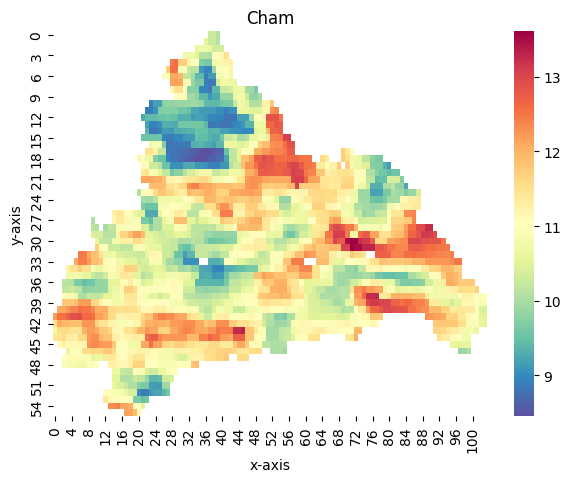

True

In [42]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Cham", 0)

### Göteborg (IV)

Göteborg


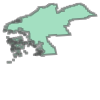

In [22]:
gid = 246 #246 
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

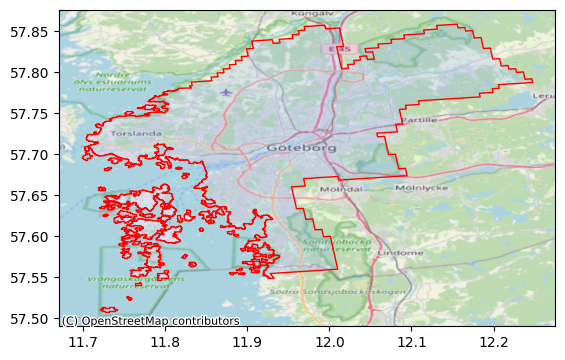

MultiPolygon


In [23]:
vizVectorGeom(INPUT)

In [24]:
i = 0
polygons_array2 = []
for polygon in INPUT.geoms:
    gridPOLYGON = processPOLYGON(polygon)
    polygons_array2.append(gridPOLYGON)
    i = i +1
    print(f"island {i}") # i th inner polygon
            

island 1
island 2
island 3
island 4
island 5
island 6
island 7
island 8
island 9
island 10
island 11
island 12
island 13
island 14
island 15
island 16
island 17
island 18
island 19
island 20
island 21
island 22
island 23
island 24
island 25
island 26
island 27
island 28
island 29
island 30
island 31
island 32
island 33
island 34
island 35
island 36
island 37
island 38
island 39
island 40
island 41
island 42
island 43
island 44
island 45
island 46
island 47
island 48
island 49
island 50
island 51
island 52
island 53
island 54
island 55
island 56
island 57
island 58
island 59
island 60
island 61
island 62
island 63
island 64
island 65
island 66
island 67
island 68


In [10]:
gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array2]

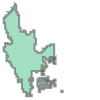

In [11]:
cu = unary_union(gridMULTI)
cu

In [391]:
IN = shapely.geometry.MultiPolygon(cu)

In [31]:
qAGGREGATE= 'select avg_cells(clip((m[145, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ')) from Surface_Temperature_Sweden as m'
query2numeric(qAGGREGATE)

None: MultiPolygon is processing


15.929312977099277

### Rosenheim (V)

Rosenheim


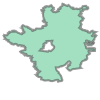

In [253]:
gid = 76 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

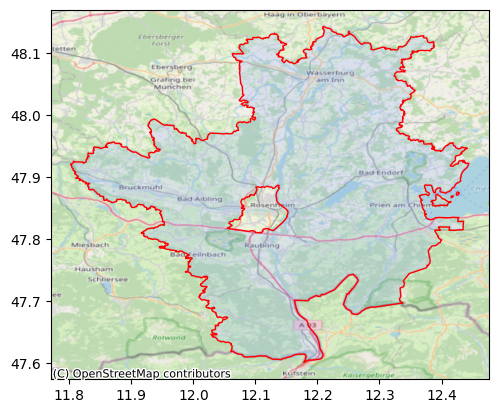

MultiPolygon


In [254]:
vizVectorGeom(INPUT)

In [255]:
qAGGREGATE= 'select avg_cells(clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


13.543174423004112

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


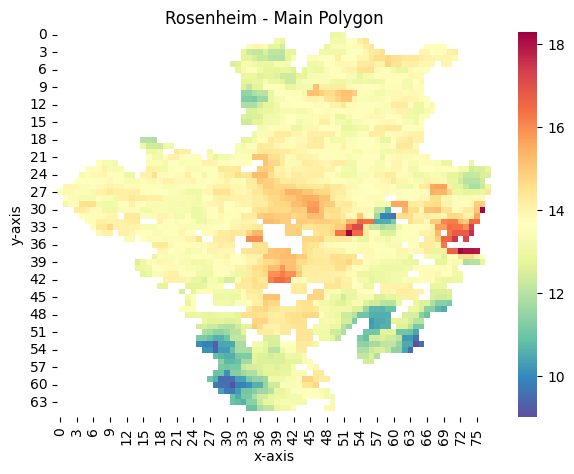

True

In [258]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Rosenheim - Main Polygon", 0)

In [9]:
INPUT.geom_type

'MultiPolygon'

In [10]:
list(INPUT.geoms)

[<POLYGON ((12.2 47.64, 12.201 47.638, 12.201 47.637, 12.202 47.636, 12.202 4...>,
 <POLYGON ((12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47...>,
 <POLYGON ((12.415 47.868, 12.415 47.868, 12.415 47.869, 12.416 47.869, 12.41...>,
 <POLYGON ((12.425 47.876, 12.426 47.876, 12.426 47.876, 12.426 47.876, 12.42...>]

In [306]:
list(INPUT.geoms)[0]

AttributeError: 'Polygon' object has no attribute 'geoms'

In [217]:
print(list(INPUT.geoms)[0])

POLYGON ((12.200161721000029 47.64013822700002, 12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.208

In [13]:
list(INPUT.geoms)[0].geom_type

'Polygon'

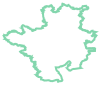

In [14]:
mainRING = list(INPUT.geoms)[0].exterior
mainRING

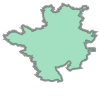

In [15]:
mainPOLYGON = Polygon(list(INPUT.geoms)[0].exterior)
mainPOLYGON

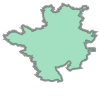

In [16]:
x = list(INPUT.geoms)[0]
Polygon(x.exterior)

In [17]:
list(INPUT.geoms[0].interiors)

[<LINEARRING (12.083 47.865, 12.078 47.865, 12.077 47.86, 12.077 47.858, 12.0...>]

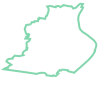

In [18]:
innerRING = list(INPUT.geoms)[0].interiors[0]
innerRING

In [19]:
list(INPUT.geoms)[0].interiors[0].geom_type

'LinearRing'

In [20]:
len(list(INPUT.geoms[0].interiors))

1

In [21]:
len(list(INPUT.geoms[2].interiors))

0

In [22]:
ring = list(INPUT.geoms)[0].interiors[0]
ring.geom_type
ring.is_closed

True

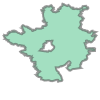

In [23]:
Polygon_assemled = mainPOLYGON.symmetric_difference(Polygon(innerRING))
Polygon_assemled

In [24]:
print(Polygon_assemled)

POLYGON ((12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.208496883000066 47.611683791000075, 12.20

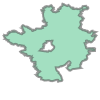

In [25]:
x = list(INPUT.geoms)[0]
x

In [26]:
if x == Polygon_assemled:
    True
else:
    print("Nope")

Nope


In [27]:
gridPOLYGON_yx = wkt.loads(processPOLYGON(mainPOLYGON))
gridPOLYGON_yx

TypeError: unsupported operand type(s) for &: 'int' and 'float'

In [28]:
gridRING_yx = wkt.loads(processPOLYGON(Polygon(innerRING)))
gridRING_yx

TypeError: unsupported operand type(s) for &: 'int' and 'float'

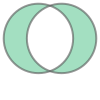

In [29]:
a = Point(1, 1).buffer(1.5)

b = Point(2, 1).buffer(1.5)

a.symmetric_difference(b)

In [30]:
x = gridPOLYGON_yx.symmetric_difference(gridRING_yx)
print(x)

NameError: name 'gridPOLYGON_yx' is not defined

In [31]:
# print(wkt.loads(str(gridPOLYGON_yx - gridRING_yx))) Worked but as a geometry collection

In [32]:
for i in range(0, len(x.interiors)):
    gridRING_yx = processRING(x.interiors[i])
    
print(grid2WKT_ring)

<function grid2WKT_ring at 0x7fb848141ee0>


In [33]:
gridPOLYGON_yx_assembled = gridPOLYGON_yx.symmetric_difference(Polygon(gridRING_yx))
        

NameError: name 'gridPOLYGON_yx' is not defined

### Expected Output

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


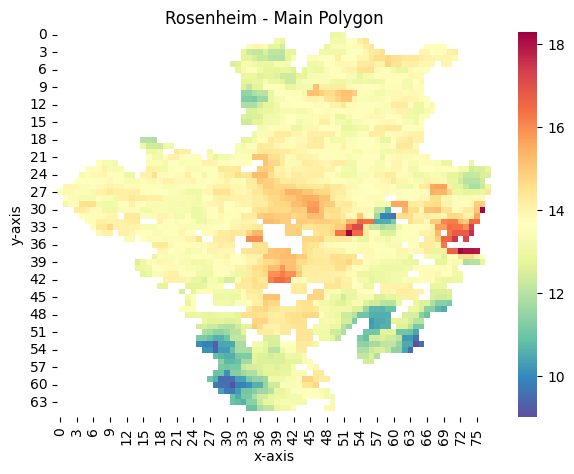

True

In [257]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Rosenheim - Main Polygon", 0)

Oberallgäu


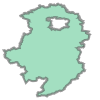

In [232]:
gid = 67 #68 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [39]:
list(INPUT.geoms)

[<POLYGON ((10.597 47.569, 10.597 47.569, 10.597 47.569, 10.597 47.568, 10.59...>,
 <POLYGON ((10.454 47.556, 10.454 47.556, 10.454 47.556, 10.454 47.556))>]

In [40]:
print(INPUT)

MULTIPOLYGON (((10.597360928000171 47.569352456000104, 10.597027419000028 47.568972182000095, 10.596877669000094 47.56880143600017, 10.596556629000133 47.56834053500012, 10.596505727000022 47.5682616740001, 10.596213182999975 47.5677754890001, 10.596176285000126 47.56771416600009, 10.596076402000108 47.567382199000065, 10.596127085000148 47.56619506400017, 10.596286496000118 47.565515285000174, 10.595824063000123 47.565212843000154, 10.595771094999975 47.56519887700006, 10.595022117000042 47.56500139700006, 10.59435970700008 47.5646786260001, 10.594034705000013 47.56448137900003, 10.593605463000074 47.56422086100014, 10.593559867000181 47.5641651040001, 10.593340442000056 47.563896192000016, 10.592924063000169 47.56338629300001, 10.592767788999993 47.56320419400015, 10.592663272000152 47.56308239100014, 10.592336584000122 47.56270145900004, 10.592209734000107 47.56255368300009, 10.591792158000032 47.562066090000144, 10.590886695000165 47.561073805000035, 10.590818370000079 47.560999665

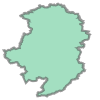

In [235]:
mainPOLYGON = Polygon(list(INPUT.geoms)[0].exterior)
mainPOLYGON

In [42]:
mainPOLYGON.area

0.171788966777449

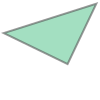

In [43]:
mainPOLYGON = Polygon(list(INPUT.geoms)[1].exterior)
mainPOLYGON

In [44]:
mainPOLYGON.area

3.200172296008267e-11

In [45]:
0.008333333332587>3.200172296008267e-11

True

In [46]:
print(mainPOLYGON)

POLYGON ((10.454469946000074 47.555739956000195, 10.454466610000111 47.55573294600015, 10.454459191000126 47.55573654200009, 10.454469946000074 47.555739956000195))


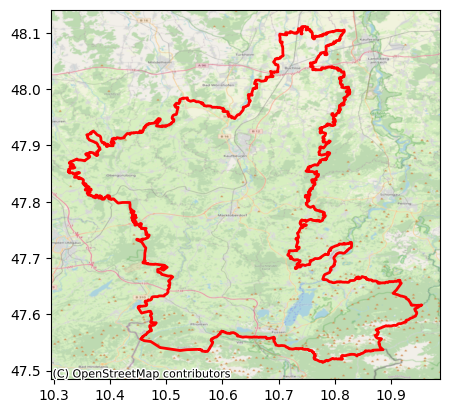

In [51]:
import contextily as cx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape

geojson = {'type': 'Polygon', 'coordinates': [[[34, 31], [32, 31], [34, 33]]]}

gdf = gpd.GeoDataFrame({'geometry':[shape(mainPOLYGON)]}, crs='EPSG:4326')
ax = gdf.plot(facecolor='none', edgecolor='red', linewidth=2)
cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)
plt.show()


In [275]:
pip install contextily

Exception ignored in: <function _after_fork at 0x7f2d81227700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
    thread._stop()
TypeError: 'Event' object is not callable


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 22.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 10.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


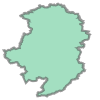

In [227]:
Polygon(mainPOLYGON.exterior)

68: Polygon is processing


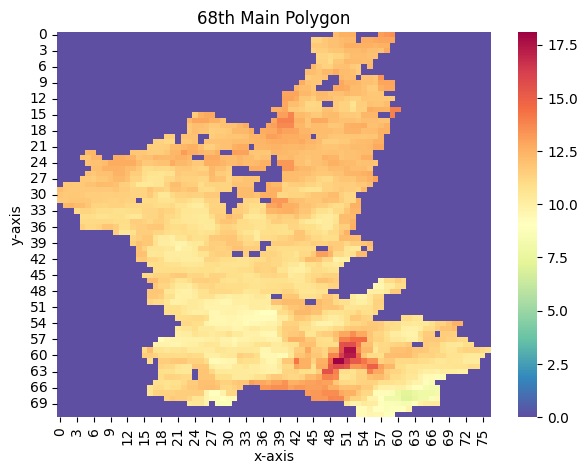

True

In [256]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(mainPOLYGON, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gid) + "th Main Polygon")

In [230]:
qAGGREGATE= 'select avg_cells(clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(mainPOLYGON, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

68: Polygon is processing


11.327328273244813

In [236]:
qAGGREGATE= 'select avg_cells(clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(mainPOLYGON, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

67: Polygon is processing


10.888405904059054

In [ ]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

Würzburg


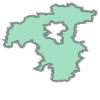

In [230]:
gid = 94
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

94: Polygon is processing
94: Polygon Ring Detected


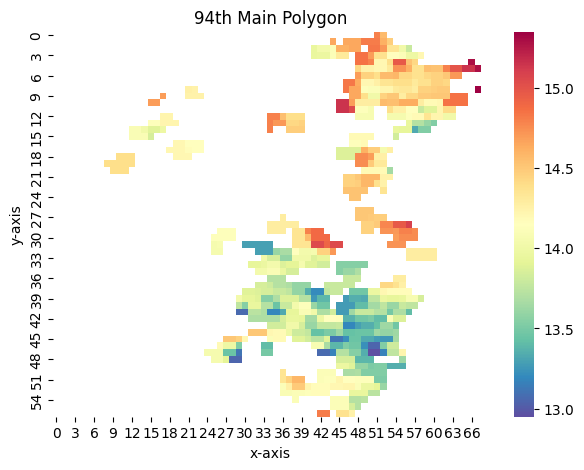

True

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 447, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "QThe client with client ID 13116 does not exist: cannot reset clien

In [231]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gid) + "th Main Polygon", 0)

In [120]:
list(INPUT.geoms)

AttributeError: 'Polygon' object has no attribute 'geoms'

In [135]:
y= processPOLYGON(list(INPUT.geoms)[0])
y

AttributeError: 'Polygon' object has no attribute 'geoms'

In [136]:
print(y)

NameError: name 'y' is not defined

In [210]:
qTIME = "select avg_cell(m[246:250, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as m" 
query2numeric(qTIME)

14.335148975105596